In [10]:
import sklearn
print(sklearn.__version__)

1.6.1


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <54A1AE05-1E14-3DA2-A8D0-062134694298> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
file_id='1Y2pakOW0OaYifT7_tHD5xa6oZnOHkmm1'
url=f'https://drive.google.com/uc?id={file_id}'
df=pd.read_csv(url).dropna(axis=1)
print(df.head())

   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         0             

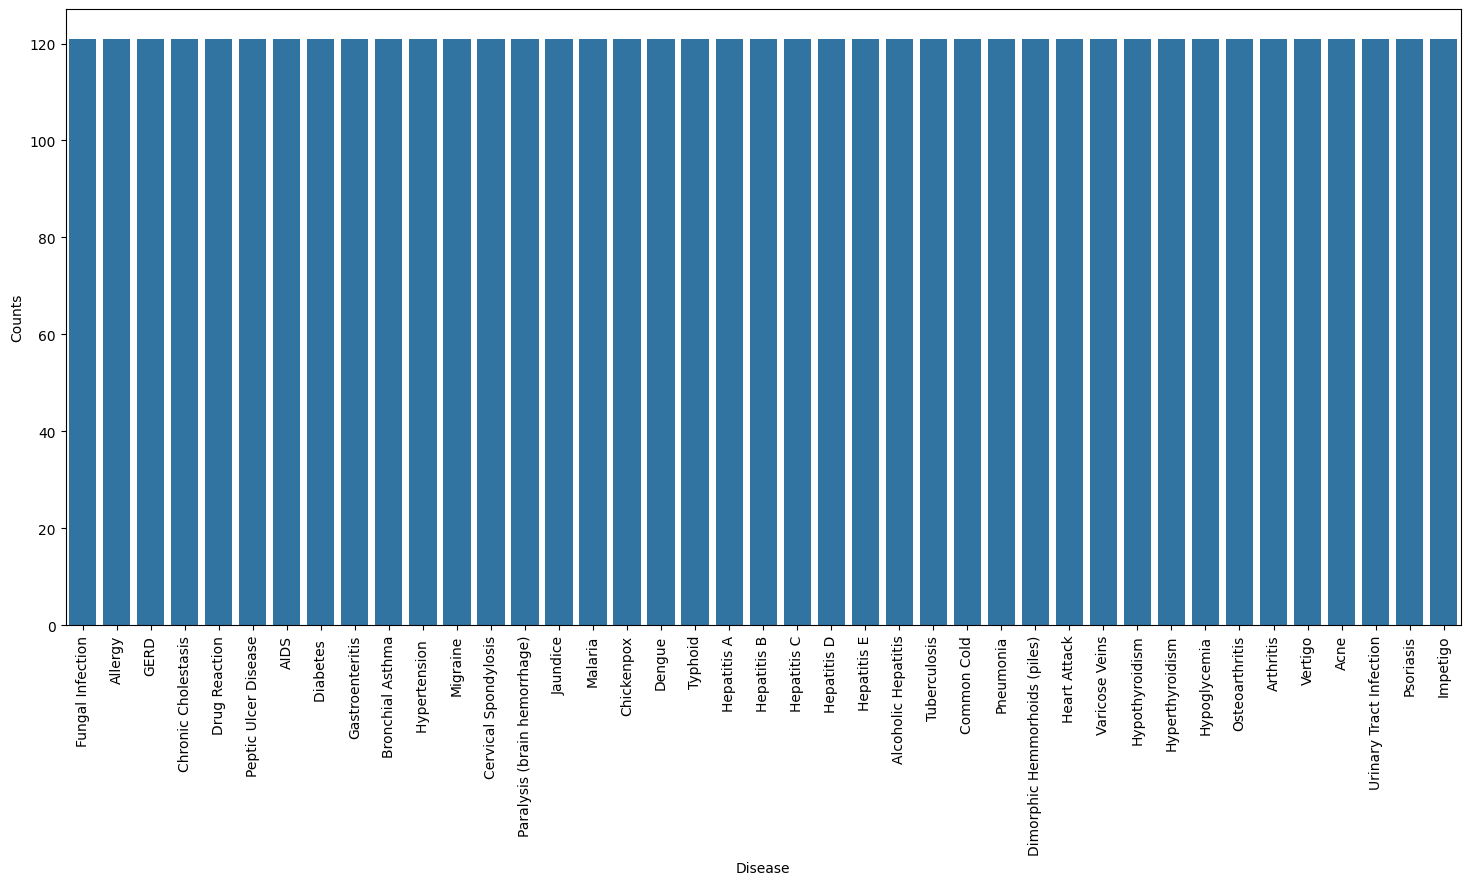

In [ ]:
#checking whether the data is balanced or not
disease_count=df["prognosis"].value_counts()
temp_df=pd.DataFrame({
    "Disease":disease_count.index,
    "Counts":disease_count.values
})
plt.figure(figsize=(18,8))
sns.barplot(x="Disease",y="Counts",data=temp_df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
encoder=LabelEncoder()
df["prognosis"]=encoder.fit_transform(df["prognosis"])

In [ ]:
X=df.drop("prognosis",axis=1)
y=df["prognosis"]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=24)
print(f"Train:{X_train.shape},{y_train.shape}")
print(f"Test:{X_test.shape},{y_test.shape}")

Train:(3968, 132),(3968,)
Test:(993, 132),(993,)


In [ ]:
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)


Best Random Forest params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best XGBoost params:", xgb_grid.best_params_)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
svm = SVC(probability=True)  # enabling probability for Voting Classifier compatibility
svm_params = {
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
svm_grid = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1)
svm_grid.fit(X_train, y_train)
print("Best SVM params:", svm_grid.best_params_)

Best SVM params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_),
        ('svm', svm_grid.best_estimator_)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:43:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importan...
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('svm', SVC(C=0.1, probability=True))],
                 voting='soft')

Ensemble Model Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        25
          13       1.00      1.00      1.00        22
          14       1.00      1.00      1.00        29
          15       1.00      1.00      1.00        15
          16       1.00 

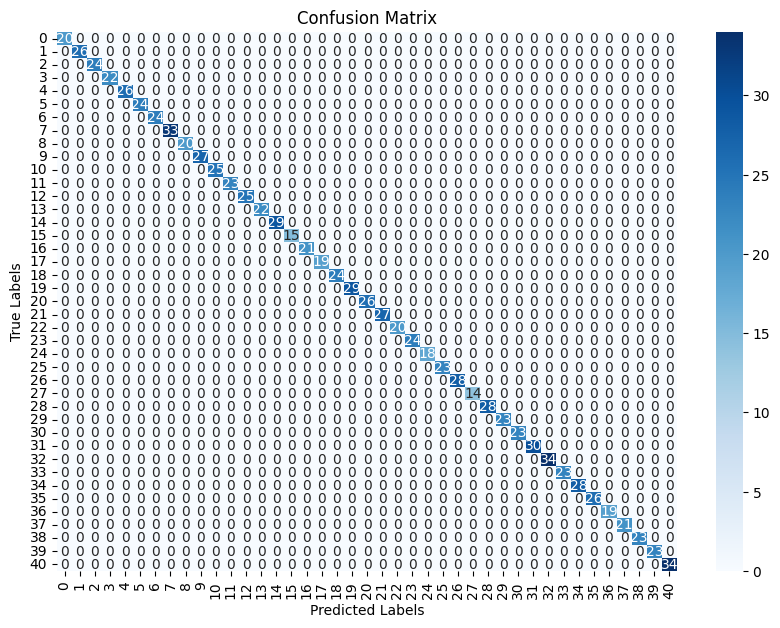

['disease_prediction_model.pkl']

In [ ]:
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

import joblib
joblib.dump(voting_clf, 'disease_prediction_model.pkl')

In [ ]:
def predict_disease(symptom_list):
    symptoms_index = X.columns.tolist()
    input_data = np.zeros(len(symptoms_index))
    for symptom in symptom_list:
        if symptom in symptoms_index:
            idx = symptoms_index.index(symptom)
            input_data[idx] = 1
        else:
            print(f"Warning: Symptom '{symptom}' not found in dataset.")
    prediction_encoded = voting_clf.predict([input_data])[0]
    predicted_disease = pd.factorize(y)[1][prediction_encoded]
    return predicted_disease

# example prediction:
new_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
predicted_disease = predict_disease(new_symptoms)
print(f"\nPredicted Disease for symptoms {new_symptoms}: {predicted_disease}")


Predicted Disease for symptoms ['itching', 'skin_rash', 'nodal_skin_eruptions']: 28


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
